In [1]:
import tensorflow as tf
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

tf.debugging.set_log_device_placement(True)


2024-12-02 06:22:13.490957: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 06:22:13.669218: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# 총 이미지 개수 출력
print(f"Total number of images: {len(image_paths)}")


Total number of images: 14577


In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
# 1. 이미지 경로 및 레이블 리스트 생성
base_dir_original = 'Training'  # 데이터가 저장된 기본 경로
image_paths = []
labels = []

for folder_name in os.listdir(base_dir_original):
    folder_path = os.path.join(base_dir_original, folder_name)
    if os.path.isdir(folder_path):
        # 레이블 추출: 폴더 이름에서 정보 파싱
        label = folder_name.split(']')[-1].split('_')[0]
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_path.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(image_path)
                labels.append(label)


# # 2. 이미지 데이터 로드 및 정규화
# # 최대 크기를 기반으로 이미지 크기를 맞추고 정규화
# max_height, max_width = 300, 300
# images = np.array([
#     tf.image.resize_with_pad(
#         tf.image.decode_image(tf.io.read_file(img_path), channels=3),
#         target_height=max_height,
#         target_width=max_width
#     ).numpy() / 255.0 for img_path in image_paths
# ])

unique_labels = sorted(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
labels = [label_to_index[label] for label in labels]

2024-12-02 06:27:24.533181: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 06:27:24.728085: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# 3. 이미지 로드 및 전처리 함수 정의
def preprocess_image(image_path, label, target_height=500, target_width=500):
    # 이미지 읽기
    image = tf.io.read_file(image_path)
    # 이미지 디코딩 및 리사이징
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, target_height, target_width)
    # 픽셀 값을 0~1로 정규화
    image = image / 255.0
    return image, label

# 4. TensorFlow 데이터 파이프라인 생성
def create_dataset(image_paths, labels, batch_size=8, buffer_size=1000, target_height=500, target_width=500):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(
        lambda path, label: preprocess_image(path, label, target_height, target_width),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.shuffle(buffer_size=buffer_size)  # 버퍼 크기 설정
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset




In [3]:
batch_size = 8
buffer_size = 1000  # 셔플 버퍼 크기 줄이기

train_dataset = create_dataset(train_paths, train_labels, batch_size=batch_size, buffer_size=buffer_size)
test_dataset = create_dataset(test_paths, test_labels, batch_size=batch_size, buffer_size=buffer_size)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-12-02 06:27:28.009381: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 06:27:28.201790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38275 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:e3:00.0, compute capability: 8.0


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model9 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(500, 500, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),  # 필터 수 감소
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),  # 뉴런 수 감소
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 추가
    tf.keras.layers.Dense(7, activation='softmax'),
])




In [5]:
# 모델 요약 출력
model9.summary()

# 모델 컴파일
model9.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 64)       0

In [6]:
result9 = model9.fit(train_dataset, validation_data=test_dataset, epochs=50)

Epoch 1/50


2024-12-02 06:27:42.973547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2024-12-02 06:27:43.228239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-02 06:27:43.291255: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x9143870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-02 06:27:43.291341: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-12-02 06:27:43.297581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-02 06:27:43.454129: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1458/1458 [==============================] - 111s 70ms/step - loss: 1.8810 - accuracy: 0.2439 - val_loss: 1.8479 - val_accuracy: 0.2606
Epoch 2/50
1458/1458 [==============================] - 99s 64ms/step - loss: 1.7616 - accuracy: 0.3165 - val_loss: 1.6447 - val_accuracy: 0.3594
Epoch 3/50
1458/1458 [==============================] - 99s 64ms/step - loss: 1.6264 - accuracy: 0.3756 - val_loss: 1.5372 - val_accuracy: 0.3992
Epoch 4/50
1458/1458 [==============================] - 99s 64ms/step - loss: 1.4866 - accuracy: 0.4362 - val_loss: 1.4863 - val_accuracy: 0.4300
Epoch 5/50
1458/1458 [==============================] - 99s 64ms/step - loss: 1.3490 - accuracy: 0.4928 - val_loss: 1.4675 - val_accuracy: 0.4434
Epoch 6/50
1458/1458 [==============================] - 99s 64ms/step - loss: 1.1458 - accuracy: 0.5730 - val_loss: 1.6108 - val_accuracy: 0.4359
Epoch 7/50
1458/1458 [==============================] - 103s 66ms/step - loss: 0.9384 - accuracy: 0.6519 - val_loss: 1.9282 - val_accu

In [8]:
score9 = model9.evaluate(test_dataset)


365/365 [==============================] - 19s 37ms/step - loss: 5.5632 - accuracy: 0.4115
[5.563217639923096, 0.41152262687683105]


In [9]:
print(score9)

[5.563217639923096, 0.41152262687683105]


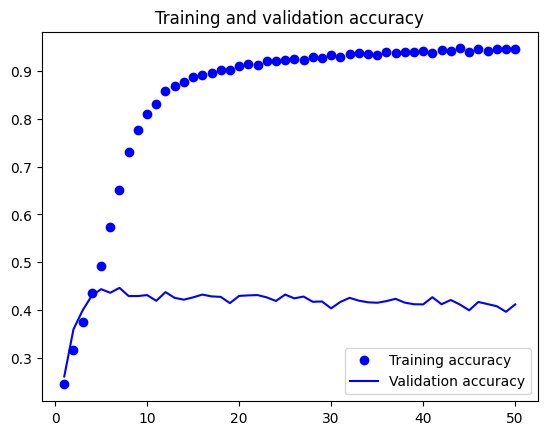

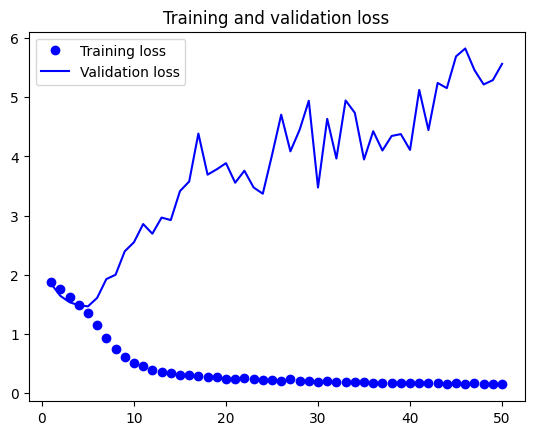

In [10]:
import matplotlib.pyplot as plt

acc9 = result9.history['accuracy']
val_acc9 = result9.history['val_accuracy']
loss9 = result9.history['loss']
val_loss9 = result9.history['val_loss']
epochs9 = range(1, len(acc9) + 1)

plt.plot(epochs9, acc9, 'bo', label='Training accuracy')
plt.plot(epochs9, val_acc9, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs9, loss9, 'bo', label='Training loss')
plt.plot(epochs9, val_loss9, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# # 그림에서도